In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abc
import yaml
from functools import reduce
import logging
import matplotlib.pyplot as plt
from tqdm import tqdm

In [34]:
# Функция обучения


def train(model, optimizer, criterion, X_train, y_train, epochs=10, batch_size=32, max_batches=100):
    setup_logging()
    precision_metric = Precision()
    recall_metric = Recall()
    
    train_losses, train_accuracies, train_precisions, train_recalls = [], [], [], []
    
    for epoch in range(epochs):
        epoch_loss = 0
        correct, total = 0, 0
        all_preds, all_targets = [], []
        batch_precisions, batch_recalls = [], []
        
        for batch_idx, (X_batch, y_batch) in enumerate(tqdm(batch_generator(X_train, y_train, batch_size), desc=f"Epoch {epoch+1}")):
            X_batch = Tensor(X_batch)
            y_batch = y_batch
            
            # Прямой проход
            output = model(X_batch)
            loss_tensor = criterion(output, y_batch)
            batch_loss = loss_tensor.data.item()
            epoch_loss += batch_loss
            
            # Подсчет метрик
            predictions = np.argmax(output.data, axis=1)
            batch_correct = np.sum(predictions == y_batch)
            correct += batch_correct
            total += y_batch.shape[0]
            all_preds.extend(predictions)
            all_targets.extend(y_batch)
            
            batch_precision = precision_metric(y_batch, predictions)
            batch_recall = recall_metric(y_batch, predictions)
            batch_precisions.append(batch_precision)
            batch_recalls.append(batch_recall)
            
            # Обратное распространение
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            
            # Обновление параметров
            all_params = model.parameters()
            grads = [p.grad for p in all_params]
            optimizer.step(grads)
            
            # Обнуляем градиенты
            for p in all_params:
                p.grad = np.zeros_like(p.grad)
            
            # Логирование после каждого батча
            batch_accuracy = batch_correct / y_batch.shape[0] * 100
            batch_log_msg = (f"Epoch {epoch+1}, Batch {batch_idx+1}: "
                             f"Loss = {batch_loss:.4f}, Accuracy = {batch_accuracy:.2f}%, "
                             f"Precision = {batch_precision:.4f}, Recall = {batch_recall:.4f}")
            print(batch_log_msg)
            logging.info(batch_log_msg)
        
        epoch_accuracy = correct / total * 100
        epoch_precision = np.mean(batch_precisions)
        epoch_recall = np.mean(batch_recalls)
        
        train_losses.append(epoch_loss / max_batches)
        train_accuracies.append(epoch_accuracy)
        train_precisions.append(epoch_precision)
        train_recalls.append(epoch_recall)
        
        log_msg = f"Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Accuracy = {epoch_accuracy:.2f}%, Precision = {epoch_precision:.4f}, Recall = {epoch_recall:.4f}"
        print(log_msg)
        logging.info(log_msg)
    
    return train_losses, train_accuracies, train_precisions, train_recalls


In [35]:
def plot_metrics(losses, accuracies, precisions, recalls):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.plot(precisions, label='Precision')
    plt.plot(recalls, label='Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title('Training Metrics')
    plt.legend()
    
    plt.show()

Epoch 1: 1it [00:09,  9.81s/it]

Epoch 1, Batch 1: Loss = 2.3878, Accuracy = 3.00%, Precision = 0.0833, Recall = 0.0667


Epoch 1: 2it [00:21, 10.97s/it]

Epoch 1, Batch 2: Loss = 2.3302, Accuracy = 8.00%, Precision = 0.0000, Recall = 0.0000


Epoch 1: 3it [00:31, 10.53s/it]

Epoch 1, Batch 3: Loss = 2.2677, Accuracy = 15.00%, Precision = 0.2353, Recall = 0.3333


Epoch 1: 4it [00:41, 10.28s/it]

Epoch 1, Batch 4: Loss = 2.1714, Accuracy = 32.00%, Precision = 0.3750, Recall = 0.2727


Epoch 1: 5it [00:52, 10.65s/it]

Epoch 1, Batch 5: Loss = 2.1631, Accuracy = 36.00%, Precision = 0.7500, Recall = 0.6429


Epoch 1: 6it [01:02, 10.42s/it]

Epoch 1, Batch 6: Loss = 2.0953, Accuracy = 43.00%, Precision = 1.0000, Recall = 0.5000


Epoch 1: 7it [01:13, 10.42s/it]

Epoch 1, Batch 7: Loss = 2.0514, Accuracy = 38.00%, Precision = 1.0000, Recall = 0.5000


Epoch 1: 8it [01:25, 10.86s/it]

Epoch 1, Batch 8: Loss = 1.9978, Accuracy = 47.00%, Precision = 1.0000, Recall = 0.6154


Epoch 1: 9it [01:35, 10.86s/it]

Epoch 1, Batch 9: Loss = 1.9848, Accuracy = 49.00%, Precision = 1.0000, Recall = 0.5000


Epoch 1: 10it [01:46, 10.83s/it]

Epoch 1, Batch 10: Loss = 1.8672, Accuracy = 50.00%, Precision = 0.7500, Recall = 0.5000


Epoch 1: 11it [01:57, 10.90s/it]

Epoch 1, Batch 11: Loss = 1.8089, Accuracy = 57.00%, Precision = 1.0000, Recall = 0.8333


Epoch 1: 12it [02:07, 10.44s/it]

Epoch 1, Batch 12: Loss = 1.7666, Accuracy = 59.00%, Precision = 1.0000, Recall = 0.5000


Epoch 1: 13it [02:16, 10.05s/it]

Epoch 1, Batch 13: Loss = 1.7224, Accuracy = 58.00%, Precision = 1.0000, Recall = 0.7692


Epoch 1: 14it [02:27, 10.40s/it]

Epoch 1, Batch 14: Loss = 1.5758, Accuracy = 68.00%, Precision = 1.0000, Recall = 0.6667


Epoch 1: 15it [02:37, 10.32s/it]

Epoch 1, Batch 15: Loss = 1.5836, Accuracy = 63.00%, Precision = 1.0000, Recall = 0.6667


Epoch 1: 16it [02:47, 10.28s/it]

Epoch 1, Batch 16: Loss = 1.4745, Accuracy = 60.00%, Precision = 0.8333, Recall = 0.7143


Epoch 1: 17it [02:57, 10.20s/it]

Epoch 1, Batch 17: Loss = 1.4969, Accuracy = 63.00%, Precision = 0.5000, Recall = 0.8000


Epoch 1: 18it [03:09, 10.79s/it]

Epoch 1, Batch 18: Loss = 1.3372, Accuracy = 65.00%, Precision = 0.6364, Recall = 0.7000


Epoch 1: 19it [03:20, 10.65s/it]

Epoch 1, Batch 19: Loss = 1.2387, Accuracy = 67.00%, Precision = 0.2500, Recall = 0.3333


Epoch 1: 20it [03:30, 10.54s/it]

Epoch 1, Batch 20: Loss = 1.1000, Accuracy = 69.00%, Precision = 0.6250, Recall = 0.6250


Epoch 1: 21it [03:41, 10.74s/it]

Epoch 1, Batch 21: Loss = 1.0268, Accuracy = 76.00%, Precision = 0.9000, Recall = 0.9000


Epoch 1: 22it [03:51, 10.33s/it]

Epoch 1, Batch 22: Loss = 0.9980, Accuracy = 73.00%, Precision = 1.0000, Recall = 0.5833


Epoch 1: 23it [04:00, 10.14s/it]

Epoch 1, Batch 23: Loss = 1.0008, Accuracy = 72.00%, Precision = 0.9167, Recall = 0.7857


Epoch 1: 24it [04:12, 10.49s/it]

Epoch 1, Batch 24: Loss = 0.8495, Accuracy = 73.00%, Precision = 0.8667, Recall = 1.0000


Epoch 1: 25it [04:22, 10.51s/it]

Epoch 1, Batch 25: Loss = 0.8150, Accuracy = 73.00%, Precision = 0.8333, Recall = 0.9091


Epoch 1: 26it [04:32, 10.37s/it]

Epoch 1, Batch 26: Loss = 0.9727, Accuracy = 69.00%, Precision = 0.9000, Recall = 0.8182


Epoch 1: 27it [04:44, 10.69s/it]

Epoch 1, Batch 27: Loss = 0.8060, Accuracy = 76.00%, Precision = 1.0000, Recall = 0.8182


Epoch 1: 28it [04:54, 10.57s/it]

Epoch 1, Batch 28: Loss = 0.9097, Accuracy = 74.00%, Precision = 0.6667, Recall = 0.8889


Epoch 1: 29it [05:04, 10.43s/it]

Epoch 1, Batch 29: Loss = 0.7543, Accuracy = 77.00%, Precision = 0.8462, Recall = 0.9167


Epoch 1: 30it [05:16, 10.90s/it]

Epoch 1, Batch 30: Loss = 0.9093, Accuracy = 75.00%, Precision = 0.6875, Recall = 0.9167


Epoch 1: 31it [05:26, 10.58s/it]

Epoch 1, Batch 31: Loss = 0.7897, Accuracy = 71.00%, Precision = 0.6000, Recall = 0.6667


Epoch 1: 32it [05:35, 10.23s/it]

Epoch 1, Batch 32: Loss = 0.5198, Accuracy = 84.00%, Precision = 0.9091, Recall = 0.9091


Epoch 1: 33it [05:45, 10.09s/it]

Epoch 1, Batch 33: Loss = 0.5526, Accuracy = 85.00%, Precision = 0.9375, Recall = 0.9375


Epoch 1: 34it [05:55,  9.93s/it]

Epoch 1, Batch 34: Loss = 0.6244, Accuracy = 82.00%, Precision = 0.7500, Recall = 0.8182


Epoch 1: 35it [06:06, 10.42s/it]

Epoch 1, Batch 35: Loss = 0.7337, Accuracy = 76.00%, Precision = 0.6250, Recall = 0.8333


Epoch 1: 36it [06:16, 10.23s/it]

Epoch 1, Batch 36: Loss = 0.6516, Accuracy = 78.00%, Precision = 0.8182, Recall = 0.9000


Epoch 1: 37it [06:26, 10.21s/it]

Epoch 1, Batch 37: Loss = 0.7808, Accuracy = 77.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 38it [06:38, 10.67s/it]

Epoch 1, Batch 38: Loss = 0.5341, Accuracy = 82.00%, Precision = 1.0000, Recall = 0.9000


Epoch 1: 39it [06:48, 10.58s/it]

Epoch 1, Batch 39: Loss = 0.5543, Accuracy = 81.00%, Precision = 0.9091, Recall = 0.9091


Epoch 1: 40it [06:58, 10.42s/it]

Epoch 1, Batch 40: Loss = 0.4755, Accuracy = 84.00%, Precision = 1.0000, Recall = 0.6364


Epoch 1: 41it [07:08, 10.31s/it]

Epoch 1, Batch 41: Loss = 0.5614, Accuracy = 77.00%, Precision = 1.0000, Recall = 0.7143


Epoch 1: 42it [07:20, 10.72s/it]

Epoch 1, Batch 42: Loss = 0.5246, Accuracy = 84.00%, Precision = 0.8333, Recall = 0.7143


Epoch 1: 43it [07:30, 10.54s/it]

Epoch 1, Batch 43: Loss = 0.6484, Accuracy = 78.00%, Precision = 0.7778, Recall = 0.8750


Epoch 1: 44it [07:41, 10.55s/it]

Epoch 1, Batch 44: Loss = 0.4717, Accuracy = 82.00%, Precision = 0.8462, Recall = 0.8462


Epoch 1: 45it [07:52, 10.74s/it]

Epoch 1, Batch 45: Loss = 0.4168, Accuracy = 87.00%, Precision = 0.8125, Recall = 0.9286


Epoch 1: 46it [08:01, 10.39s/it]

Epoch 1, Batch 46: Loss = 0.4672, Accuracy = 86.00%, Precision = 0.8462, Recall = 0.9167


Epoch 1: 47it [08:11, 10.27s/it]

Epoch 1, Batch 47: Loss = 0.4237, Accuracy = 86.00%, Precision = 0.6923, Recall = 0.8182


Epoch 1: 48it [08:23, 10.61s/it]

Epoch 1, Batch 48: Loss = 0.5316, Accuracy = 83.00%, Precision = 0.8182, Recall = 1.0000


Epoch 1: 49it [08:33, 10.42s/it]

Epoch 1, Batch 49: Loss = 0.3399, Accuracy = 91.00%, Precision = 0.8889, Recall = 0.8889


Epoch 1: 50it [08:43, 10.39s/it]

Epoch 1, Batch 50: Loss = 0.4374, Accuracy = 85.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 51it [08:55, 10.73s/it]

Epoch 1, Batch 51: Loss = 0.5705, Accuracy = 84.00%, Precision = 0.9167, Recall = 0.9167


Epoch 1: 52it [09:05, 10.63s/it]

Epoch 1, Batch 52: Loss = 0.5416, Accuracy = 84.00%, Precision = 0.5000, Recall = 1.0000


Epoch 1: 53it [09:15, 10.43s/it]

Epoch 1, Batch 53: Loss = 0.6004, Accuracy = 79.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 54it [09:26, 10.71s/it]

Epoch 1, Batch 54: Loss = 0.4735, Accuracy = 82.00%, Precision = 0.8182, Recall = 1.0000


Epoch 1: 55it [09:36, 10.38s/it]

Epoch 1, Batch 55: Loss = 0.4135, Accuracy = 89.00%, Precision = 0.9286, Recall = 1.0000


Epoch 1: 56it [09:46, 10.32s/it]

Epoch 1, Batch 56: Loss = 0.2583, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 57it [09:57, 10.36s/it]

Epoch 1, Batch 57: Loss = 0.4662, Accuracy = 85.00%, Precision = 0.9000, Recall = 0.8182


Epoch 1: 58it [10:08, 10.77s/it]

Epoch 1, Batch 58: Loss = 0.6015, Accuracy = 83.00%, Precision = 0.8000, Recall = 0.9231


Epoch 1: 59it [10:18, 10.34s/it]

Epoch 1, Batch 59: Loss = 0.4550, Accuracy = 87.00%, Precision = 1.0000, Recall = 0.8571


Epoch 1: 60it [10:28, 10.28s/it]

Epoch 1, Batch 60: Loss = 0.4207, Accuracy = 84.00%, Precision = 1.0000, Recall = 0.8750


Epoch 1: 61it [10:40, 10.82s/it]

Epoch 1, Batch 61: Loss = 0.5736, Accuracy = 88.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 62it [10:51, 10.75s/it]

Epoch 1, Batch 62: Loss = 0.5174, Accuracy = 82.00%, Precision = 1.0000, Recall = 0.8182


Epoch 1: 63it [11:02, 10.84s/it]

Epoch 1, Batch 63: Loss = 0.4787, Accuracy = 85.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 64it [11:14, 11.30s/it]

Epoch 1, Batch 64: Loss = 0.3855, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 65it [11:24, 10.88s/it]

Epoch 1, Batch 65: Loss = 0.4594, Accuracy = 81.00%, Precision = 0.7692, Recall = 0.9091


Epoch 1: 66it [11:33, 10.40s/it]

Epoch 1, Batch 66: Loss = 0.4499, Accuracy = 88.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 67it [11:45, 10.71s/it]

Epoch 1, Batch 67: Loss = 0.5546, Accuracy = 83.00%, Precision = 0.8571, Recall = 0.6000


Epoch 1: 68it [11:56, 10.79s/it]

Epoch 1, Batch 68: Loss = 0.5798, Accuracy = 81.00%, Precision = 0.7647, Recall = 0.9286


Epoch 1: 69it [12:07, 10.86s/it]

Epoch 1, Batch 69: Loss = 0.3629, Accuracy = 88.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 70it [12:19, 11.29s/it]

Epoch 1, Batch 70: Loss = 0.3254, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 71it [12:30, 11.22s/it]

Epoch 1, Batch 71: Loss = 0.4943, Accuracy = 84.00%, Precision = 0.8095, Recall = 1.0000


Epoch 1: 72it [12:40, 10.92s/it]

Epoch 1, Batch 72: Loss = 0.3732, Accuracy = 86.00%, Precision = 0.8667, Recall = 1.0000


Epoch 1: 73it [12:51, 10.80s/it]

Epoch 1, Batch 73: Loss = 0.3997, Accuracy = 89.00%, Precision = 0.9000, Recall = 0.9000


Epoch 1: 74it [13:01, 10.56s/it]

Epoch 1, Batch 74: Loss = 0.3769, Accuracy = 87.00%, Precision = 0.8889, Recall = 0.8000


Epoch 1: 75it [13:11, 10.52s/it]

Epoch 1, Batch 75: Loss = 0.3668, Accuracy = 89.00%, Precision = 0.7500, Recall = 0.9000


Epoch 1: 76it [13:23, 11.01s/it]

Epoch 1, Batch 76: Loss = 0.6655, Accuracy = 84.00%, Precision = 0.8750, Recall = 0.8750


Epoch 1: 77it [13:33, 10.75s/it]

Epoch 1, Batch 77: Loss = 0.3079, Accuracy = 88.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 78it [13:44, 10.74s/it]

Epoch 1, Batch 78: Loss = 0.3241, Accuracy = 88.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 79it [13:56, 11.23s/it]

Epoch 1, Batch 79: Loss = 0.5015, Accuracy = 90.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 80it [14:07, 11.04s/it]

Epoch 1, Batch 80: Loss = 0.2807, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 81it [14:18, 10.97s/it]

Epoch 1, Batch 81: Loss = 0.3368, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 82it [14:30, 11.34s/it]

Epoch 1, Batch 82: Loss = 0.4747, Accuracy = 86.00%, Precision = 0.8824, Recall = 1.0000


Epoch 1: 83it [14:41, 11.20s/it]

Epoch 1, Batch 83: Loss = 0.3566, Accuracy = 86.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 84it [14:52, 11.03s/it]

Epoch 1, Batch 84: Loss = 0.3431, Accuracy = 87.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 85it [15:04, 11.39s/it]

Epoch 1, Batch 85: Loss = 0.3699, Accuracy = 91.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 86it [15:15, 11.26s/it]

Epoch 1, Batch 86: Loss = 0.4723, Accuracy = 84.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 87it [15:26, 11.19s/it]

Epoch 1, Batch 87: Loss = 0.4373, Accuracy = 86.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 88it [15:38, 11.52s/it]

Epoch 1, Batch 88: Loss = 0.2831, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 89it [15:49, 11.34s/it]

Epoch 1, Batch 89: Loss = 0.3372, Accuracy = 87.00%, Precision = 0.8750, Recall = 0.7778


Epoch 1: 90it [16:00, 11.21s/it]

Epoch 1, Batch 90: Loss = 0.4232, Accuracy = 86.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 91it [16:12, 11.48s/it]

Epoch 1, Batch 91: Loss = 0.3529, Accuracy = 88.00%, Precision = 1.0000, Recall = 0.8750


Epoch 1: 92it [16:23, 11.20s/it]

Epoch 1, Batch 92: Loss = 0.2779, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.8667


Epoch 1: 93it [16:33, 11.05s/it]

Epoch 1, Batch 93: Loss = 0.2880, Accuracy = 91.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 94it [16:45, 11.37s/it]

Epoch 1, Batch 94: Loss = 0.3835, Accuracy = 87.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 95it [16:56, 11.06s/it]

Epoch 1, Batch 95: Loss = 0.3225, Accuracy = 88.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 96it [17:06, 10.91s/it]

Epoch 1, Batch 96: Loss = 0.2825, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 97it [17:18, 11.24s/it]

Epoch 1, Batch 97: Loss = 0.4130, Accuracy = 90.00%, Precision = 0.7500, Recall = 1.0000


Epoch 1: 98it [17:29, 11.10s/it]

Epoch 1, Batch 98: Loss = 0.3815, Accuracy = 84.00%, Precision = 0.9286, Recall = 0.8667


Epoch 1: 99it [17:40, 10.98s/it]

Epoch 1, Batch 99: Loss = 0.3779, Accuracy = 91.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 100it [17:52, 11.30s/it]

Epoch 1, Batch 100: Loss = 0.2429, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 101it [18:03, 11.15s/it]

Epoch 1, Batch 101: Loss = 0.3407, Accuracy = 89.00%, Precision = 0.7500, Recall = 1.0000


Epoch 1: 102it [18:13, 10.93s/it]

Epoch 1, Batch 102: Loss = 0.5097, Accuracy = 85.00%, Precision = 0.8182, Recall = 0.9000


Epoch 1: 103it [18:25, 11.18s/it]

Epoch 1, Batch 103: Loss = 0.3132, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 104it [18:36, 11.12s/it]

Epoch 1, Batch 104: Loss = 0.4473, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 105it [18:47, 11.10s/it]

Epoch 1, Batch 105: Loss = 0.2683, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 106it [18:59, 11.32s/it]

Epoch 1, Batch 106: Loss = 0.4893, Accuracy = 85.00%, Precision = 1.0000, Recall = 0.9286


Epoch 1: 107it [19:10, 11.20s/it]

Epoch 1, Batch 107: Loss = 0.4767, Accuracy = 88.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 108it [19:20, 11.01s/it]

Epoch 1, Batch 108: Loss = 0.2408, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 109it [19:32, 11.38s/it]

Epoch 1, Batch 109: Loss = 0.5950, Accuracy = 83.00%, Precision = 0.7857, Recall = 1.0000


Epoch 1: 110it [19:43, 11.24s/it]

Epoch 1, Batch 110: Loss = 0.4755, Accuracy = 88.00%, Precision = 1.0000, Recall = 0.8889


Epoch 1: 111it [19:54, 11.17s/it]

Epoch 1, Batch 111: Loss = 0.3200, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.9545


Epoch 1: 112it [20:06, 11.47s/it]

Epoch 1, Batch 112: Loss = 0.4376, Accuracy = 87.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 113it [20:17, 11.32s/it]

Epoch 1, Batch 113: Loss = 0.5020, Accuracy = 85.00%, Precision = 0.8750, Recall = 0.8750


Epoch 1: 114it [20:28, 11.18s/it]

Epoch 1, Batch 114: Loss = 0.3114, Accuracy = 88.00%, Precision = 0.9286, Recall = 0.9286


Epoch 1: 115it [20:40, 11.43s/it]

Epoch 1, Batch 115: Loss = 0.4648, Accuracy = 86.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 116it [20:53, 11.74s/it]

Epoch 1, Batch 116: Loss = 0.1918, Accuracy = 95.00%, Precision = 0.9286, Recall = 1.0000


Epoch 1: 117it [21:04, 11.49s/it]

Epoch 1, Batch 117: Loss = 0.3961, Accuracy = 90.00%, Precision = 0.8824, Recall = 1.0000


Epoch 1: 118it [21:16, 11.74s/it]

Epoch 1, Batch 118: Loss = 0.3542, Accuracy = 87.00%, Precision = 0.9000, Recall = 0.9000


Epoch 1: 119it [21:27, 11.58s/it]

Epoch 1, Batch 119: Loss = 0.2925, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 120it [21:38, 11.32s/it]

Epoch 1, Batch 120: Loss = 0.2766, Accuracy = 90.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 121it [21:50, 11.42s/it]

Epoch 1, Batch 121: Loss = 0.4232, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 122it [22:00, 11.08s/it]

Epoch 1, Batch 122: Loss = 0.3834, Accuracy = 86.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 123it [22:11, 10.95s/it]

Epoch 1, Batch 123: Loss = 0.3338, Accuracy = 90.00%, Precision = 0.9231, Recall = 1.0000


Epoch 1: 124it [22:22, 11.05s/it]

Epoch 1, Batch 124: Loss = 0.3240, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 125it [22:33, 11.18s/it]

Epoch 1, Batch 125: Loss = 0.4401, Accuracy = 88.00%, Precision = 0.8750, Recall = 0.8750


Epoch 1: 126it [22:46, 11.69s/it]

Epoch 1, Batch 126: Loss = 0.2677, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.9091


Epoch 1: 127it [23:01, 12.52s/it]

Epoch 1, Batch 127: Loss = 0.3806, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 128it [23:12, 12.05s/it]

Epoch 1, Batch 128: Loss = 0.4983, Accuracy = 84.00%, Precision = 0.9000, Recall = 0.9000


Epoch 1: 129it [23:22, 11.69s/it]

Epoch 1, Batch 129: Loss = 0.3004, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 130it [23:35, 11.87s/it]

Epoch 1, Batch 130: Loss = 0.3545, Accuracy = 92.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 131it [23:45, 11.41s/it]

Epoch 1, Batch 131: Loss = 0.2784, Accuracy = 90.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 132it [23:55, 11.10s/it]

Epoch 1, Batch 132: Loss = 0.4685, Accuracy = 87.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 133it [24:07, 11.34s/it]

Epoch 1, Batch 133: Loss = 0.4397, Accuracy = 89.00%, Precision = 0.8889, Recall = 0.8889


Epoch 1: 134it [24:18, 11.13s/it]

Epoch 1, Batch 134: Loss = 0.2968, Accuracy = 92.00%, Precision = 0.9286, Recall = 1.0000


Epoch 1: 135it [24:28, 10.79s/it]

Epoch 1, Batch 135: Loss = 0.3011, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 136it [24:39, 10.92s/it]

Epoch 1, Batch 136: Loss = 0.3627, Accuracy = 89.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 137it [24:50, 10.83s/it]

Epoch 1, Batch 137: Loss = 0.5791, Accuracy = 85.00%, Precision = 1.0000, Recall = 0.8889


Epoch 1: 138it [25:01, 10.81s/it]

Epoch 1, Batch 138: Loss = 0.3754, Accuracy = 89.00%, Precision = 1.0000, Recall = 0.8333


Epoch 1: 139it [25:13, 11.28s/it]

Epoch 1, Batch 139: Loss = 0.4547, Accuracy = 86.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 140it [25:24, 11.08s/it]

Epoch 1, Batch 140: Loss = 0.3584, Accuracy = 88.00%, Precision = 0.6667, Recall = 1.0000


Epoch 1: 141it [25:35, 11.25s/it]

Epoch 1, Batch 141: Loss = 0.3737, Accuracy = 88.00%, Precision = 0.8182, Recall = 0.9000


Epoch 1: 142it [25:48, 11.85s/it]

Epoch 1, Batch 142: Loss = 0.2904, Accuracy = 92.00%, Precision = 0.9545, Recall = 1.0000


Epoch 1: 143it [25:59, 11.47s/it]

Epoch 1, Batch 143: Loss = 0.2920, Accuracy = 92.00%, Precision = 1.0000, Recall = 0.8889


Epoch 1: 144it [26:10, 11.28s/it]

Epoch 1, Batch 144: Loss = 0.2042, Accuracy = 94.00%, Precision = 0.9545, Recall = 1.0000


Epoch 1: 145it [26:21, 11.31s/it]

Epoch 1, Batch 145: Loss = 0.3423, Accuracy = 90.00%, Precision = 0.9231, Recall = 1.0000


Epoch 1: 146it [26:31, 10.97s/it]

Epoch 1, Batch 146: Loss = 0.3809, Accuracy = 88.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 147it [26:42, 10.77s/it]

Epoch 1, Batch 147: Loss = 0.3844, Accuracy = 91.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 148it [26:54, 11.13s/it]

Epoch 1, Batch 148: Loss = 0.3980, Accuracy = 88.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 149it [27:04, 10.76s/it]

Epoch 1, Batch 149: Loss = 0.4082, Accuracy = 83.00%, Precision = 1.0000, Recall = 0.9286


Epoch 1: 150it [27:14, 10.72s/it]

Epoch 1, Batch 150: Loss = 0.3848, Accuracy = 90.00%, Precision = 0.9167, Recall = 0.9167


Epoch 1: 151it [27:27, 11.24s/it]

Epoch 1, Batch 151: Loss = 0.3702, Accuracy = 91.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 152it [27:37, 10.91s/it]

Epoch 1, Batch 152: Loss = 0.4040, Accuracy = 92.00%, Precision = 0.8182, Recall = 1.0000


Epoch 1: 153it [27:48, 10.84s/it]

Epoch 1, Batch 153: Loss = 0.3069, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.9231


Epoch 1: 154it [27:59, 11.13s/it]

Epoch 1, Batch 154: Loss = 0.2712, Accuracy = 91.00%, Precision = 0.8333, Recall = 1.0000


Epoch 1: 155it [28:09, 10.82s/it]

Epoch 1, Batch 155: Loss = 0.4466, Accuracy = 90.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 156it [28:20, 10.70s/it]

Epoch 1, Batch 156: Loss = 0.3937, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 157it [28:32, 11.10s/it]

Epoch 1, Batch 157: Loss = 0.4581, Accuracy = 83.00%, Precision = 1.0000, Recall = 0.8667


Epoch 1: 158it [28:42, 10.90s/it]

Epoch 1, Batch 158: Loss = 0.2342, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.9231


Epoch 1: 159it [28:53, 10.89s/it]

Epoch 1, Batch 159: Loss = 0.3016, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 160it [29:06, 11.50s/it]

Epoch 1, Batch 160: Loss = 0.3869, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 161it [29:19, 11.99s/it]

Epoch 1, Batch 161: Loss = 0.6755, Accuracy = 86.00%, Precision = 0.9286, Recall = 1.0000


Epoch 1: 162it [29:30, 11.62s/it]

Epoch 1, Batch 162: Loss = 0.3729, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 163it [29:42, 11.69s/it]

Epoch 1, Batch 163: Loss = 0.5313, Accuracy = 84.00%, Precision = 1.0000, Recall = 0.9091


Epoch 1: 164it [29:52, 11.20s/it]

Epoch 1, Batch 164: Loss = 0.2609, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 165it [30:02, 10.83s/it]

Epoch 1, Batch 165: Loss = 0.3289, Accuracy = 92.00%, Precision = 0.9231, Recall = 0.9231


Epoch 1: 166it [30:14, 11.23s/it]

Epoch 1, Batch 166: Loss = 0.4323, Accuracy = 88.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 167it [30:24, 10.96s/it]

Epoch 1, Batch 167: Loss = 0.3498, Accuracy = 91.00%, Precision = 0.8824, Recall = 1.0000


Epoch 1: 168it [30:35, 10.81s/it]

Epoch 1, Batch 168: Loss = 0.3350, Accuracy = 87.00%, Precision = 0.8571, Recall = 1.0000


Epoch 1: 169it [30:47, 11.15s/it]

Epoch 1, Batch 169: Loss = 0.4159, Accuracy = 89.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 170it [30:58, 11.07s/it]

Epoch 1, Batch 170: Loss = 0.1602, Accuracy = 94.00%, Precision = 0.9091, Recall = 0.9091


Epoch 1: 171it [31:08, 10.97s/it]

Epoch 1, Batch 171: Loss = 0.2614, Accuracy = 91.00%, Precision = 0.8333, Recall = 0.8333


Epoch 1: 172it [31:20, 11.32s/it]

Epoch 1, Batch 172: Loss = 0.3201, Accuracy = 90.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 173it [31:31, 11.13s/it]

Epoch 1, Batch 173: Loss = 0.1746, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 174it [31:41, 10.88s/it]

Epoch 1, Batch 174: Loss = 0.3272, Accuracy = 91.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 175it [31:54, 11.37s/it]

Epoch 1, Batch 175: Loss = 0.3780, Accuracy = 88.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 176it [32:05, 11.27s/it]

Epoch 1, Batch 176: Loss = 0.4525, Accuracy = 84.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 177it [32:16, 11.04s/it]

Epoch 1, Batch 177: Loss = 0.1345, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 178it [32:27, 11.29s/it]

Epoch 1, Batch 178: Loss = 0.2823, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.8889


Epoch 1: 179it [32:37, 10.90s/it]

Epoch 1, Batch 179: Loss = 0.3092, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 180it [32:49, 11.25s/it]

Epoch 1, Batch 180: Loss = 0.2344, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 181it [33:05, 12.65s/it]

Epoch 1, Batch 181: Loss = 0.2746, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.9000


Epoch 1: 182it [33:20, 13.12s/it]

Epoch 1, Batch 182: Loss = 0.2331, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 183it [33:32, 12.98s/it]

Epoch 1, Batch 183: Loss = 0.2134, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 184it [33:43, 12.27s/it]

Epoch 1, Batch 184: Loss = 0.3564, Accuracy = 88.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 185it [33:53, 11.61s/it]

Epoch 1, Batch 185: Loss = 0.2576, Accuracy = 93.00%, Precision = 0.9333, Recall = 0.9333


Epoch 1: 186it [34:04, 11.55s/it]

Epoch 1, Batch 186: Loss = 0.3994, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 187it [34:15, 11.22s/it]

Epoch 1, Batch 187: Loss = 0.3963, Accuracy = 86.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 188it [34:28, 11.90s/it]

Epoch 1, Batch 188: Loss = 0.4297, Accuracy = 90.00%, Precision = 1.0000, Recall = 0.9000


Epoch 1: 189it [34:42, 12.57s/it]

Epoch 1, Batch 189: Loss = 0.3024, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 190it [34:55, 12.70s/it]

Epoch 1, Batch 190: Loss = 0.2898, Accuracy = 89.00%, Precision = 0.8000, Recall = 1.0000


Epoch 1: 191it [35:06, 12.15s/it]

Epoch 1, Batch 191: Loss = 0.2615, Accuracy = 89.00%, Precision = 0.9375, Recall = 0.9375


Epoch 1: 192it [35:18, 12.10s/it]

Epoch 1, Batch 192: Loss = 0.2628, Accuracy = 90.00%, Precision = 0.9333, Recall = 1.0000


Epoch 1: 193it [35:29, 11.75s/it]

Epoch 1, Batch 193: Loss = 0.2901, Accuracy = 90.00%, Precision = 0.8333, Recall = 1.0000


Epoch 1: 194it [35:40, 11.48s/it]

Epoch 1, Batch 194: Loss = 0.2185, Accuracy = 91.00%, Precision = 0.9545, Recall = 1.0000


Epoch 1: 195it [35:53, 11.77s/it]

Epoch 1, Batch 195: Loss = 0.3105, Accuracy = 89.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 196it [36:03, 11.44s/it]

Epoch 1, Batch 196: Loss = 0.2460, Accuracy = 92.00%, Precision = 1.0000, Recall = 0.9286


Epoch 1: 197it [36:14, 11.16s/it]

Epoch 1, Batch 197: Loss = 0.4830, Accuracy = 89.00%, Precision = 0.7500, Recall = 0.9231


Epoch 1: 198it [36:26, 11.50s/it]

Epoch 1, Batch 198: Loss = 0.2660, Accuracy = 96.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 199it [36:37, 11.50s/it]

Epoch 1, Batch 199: Loss = 0.2498, Accuracy = 93.00%, Precision = 0.8571, Recall = 1.0000


Epoch 1: 200it [36:52, 12.51s/it]

Epoch 1, Batch 200: Loss = 0.2423, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 201it [37:03, 12.01s/it]

Epoch 1, Batch 201: Loss = 0.4586, Accuracy = 84.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 202it [37:13, 11.48s/it]

Epoch 1, Batch 202: Loss = 0.2786, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 203it [37:26, 11.69s/it]

Epoch 1, Batch 203: Loss = 0.5087, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 204it [37:37, 11.45s/it]

Epoch 1, Batch 204: Loss = 0.2604, Accuracy = 93.00%, Precision = 0.8333, Recall = 0.9091


Epoch 1: 205it [37:48, 11.48s/it]

Epoch 1, Batch 205: Loss = 0.3608, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 206it [38:01, 12.02s/it]

Epoch 1, Batch 206: Loss = 0.4020, Accuracy = 87.00%, Precision = 1.0000, Recall = 0.7500


Epoch 1: 207it [38:12, 11.68s/it]

Epoch 1, Batch 207: Loss = 0.6477, Accuracy = 84.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 208it [38:23, 11.36s/it]

Epoch 1, Batch 208: Loss = 0.3569, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 209it [38:35, 11.67s/it]

Epoch 1, Batch 209: Loss = 0.3294, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 210it [38:46, 11.50s/it]

Epoch 1, Batch 210: Loss = 0.3127, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 211it [38:58, 11.65s/it]

Epoch 1, Batch 211: Loss = 0.3903, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 212it [39:11, 11.83s/it]

Epoch 1, Batch 212: Loss = 0.3625, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 213it [39:21, 11.48s/it]

Epoch 1, Batch 213: Loss = 0.3204, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 214it [39:32, 11.30s/it]

Epoch 1, Batch 214: Loss = 0.5370, Accuracy = 88.00%, Precision = 1.0000, Recall = 0.9000


Epoch 1: 215it [39:44, 11.60s/it]

Epoch 1, Batch 215: Loss = 0.3694, Accuracy = 90.00%, Precision = 0.9444, Recall = 0.9444


Epoch 1: 216it [39:55, 11.33s/it]

Epoch 1, Batch 216: Loss = 0.2179, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 217it [40:06, 11.21s/it]

Epoch 1, Batch 217: Loss = 0.1622, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 218it [40:19, 11.60s/it]

Epoch 1, Batch 218: Loss = 0.3433, Accuracy = 90.00%, Precision = 0.8333, Recall = 1.0000


Epoch 1: 219it [40:29, 11.25s/it]

Epoch 1, Batch 219: Loss = 0.2838, Accuracy = 91.00%, Precision = 0.8571, Recall = 1.0000


Epoch 1: 220it [40:40, 11.12s/it]

Epoch 1, Batch 220: Loss = 0.2109, Accuracy = 95.00%, Precision = 0.8571, Recall = 1.0000


Epoch 1: 221it [40:52, 11.55s/it]

Epoch 1, Batch 221: Loss = 0.2559, Accuracy = 93.00%, Precision = 0.8000, Recall = 1.0000


Epoch 1: 222it [41:03, 11.29s/it]

Epoch 1, Batch 222: Loss = 0.2188, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 223it [41:14, 11.21s/it]

Epoch 1, Batch 223: Loss = 0.3173, Accuracy = 89.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 224it [41:27, 11.61s/it]

Epoch 1, Batch 224: Loss = 0.4727, Accuracy = 85.00%, Precision = 1.0000, Recall = 0.8667


Epoch 1: 225it [41:37, 11.32s/it]

Epoch 1, Batch 225: Loss = 0.1469, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 226it [41:48, 11.23s/it]

Epoch 1, Batch 226: Loss = 0.3226, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 227it [42:01, 11.61s/it]

Epoch 1, Batch 227: Loss = 0.2685, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.9231


Epoch 1: 228it [42:12, 11.37s/it]

Epoch 1, Batch 228: Loss = 0.2667, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 229it [42:22, 11.19s/it]

Epoch 1, Batch 229: Loss = 0.3989, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 230it [42:35, 11.49s/it]

Epoch 1, Batch 230: Loss = 0.3153, Accuracy = 89.00%, Precision = 0.9375, Recall = 0.9375


Epoch 1: 231it [42:45, 11.29s/it]

Epoch 1, Batch 231: Loss = 0.4163, Accuracy = 91.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 232it [42:56, 11.16s/it]

Epoch 1, Batch 232: Loss = 0.3061, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 233it [43:08, 11.49s/it]

Epoch 1, Batch 233: Loss = 0.2496, Accuracy = 90.00%, Precision = 0.9375, Recall = 1.0000


Epoch 1: 234it [43:19, 11.26s/it]

Epoch 1, Batch 234: Loss = 0.2794, Accuracy = 92.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 235it [43:30, 11.14s/it]

Epoch 1, Batch 235: Loss = 0.3057, Accuracy = 88.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 236it [43:42, 11.50s/it]

Epoch 1, Batch 236: Loss = 0.2104, Accuracy = 95.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 237it [43:53, 11.34s/it]

Epoch 1, Batch 237: Loss = 0.3699, Accuracy = 87.00%, Precision = 0.6250, Recall = 1.0000


Epoch 1: 238it [44:04, 11.25s/it]

Epoch 1, Batch 238: Loss = 0.2192, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 239it [44:17, 11.54s/it]

Epoch 1, Batch 239: Loss = 0.2809, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 240it [44:27, 11.26s/it]

Epoch 1, Batch 240: Loss = 0.3282, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 241it [44:38, 11.14s/it]

Epoch 1, Batch 241: Loss = 0.3041, Accuracy = 90.00%, Precision = 1.0000, Recall = 0.8889


Epoch 1: 242it [44:51, 11.73s/it]

Epoch 1, Batch 242: Loss = 0.3775, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 243it [45:03, 11.68s/it]

Epoch 1, Batch 243: Loss = 0.6345, Accuracy = 84.00%, Precision = 1.0000, Recall = 0.8000


Epoch 1: 244it [45:15, 11.76s/it]

Epoch 1, Batch 244: Loss = 0.2863, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 245it [45:26, 11.49s/it]

Epoch 1, Batch 245: Loss = 0.3521, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 246it [45:36, 11.30s/it]

Epoch 1, Batch 246: Loss = 0.2859, Accuracy = 89.00%, Precision = 0.9231, Recall = 0.9231


Epoch 1: 247it [45:49, 11.70s/it]

Epoch 1, Batch 247: Loss = 0.2708, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 248it [46:02, 12.07s/it]

Epoch 1, Batch 248: Loss = 0.2538, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.8571


Epoch 1: 249it [46:15, 12.41s/it]

Epoch 1, Batch 249: Loss = 0.2865, Accuracy = 91.00%, Precision = 0.7500, Recall = 1.0000


Epoch 1: 250it [46:29, 12.91s/it]

Epoch 1, Batch 250: Loss = 0.2201, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 251it [46:40, 12.25s/it]

Epoch 1, Batch 251: Loss = 0.3590, Accuracy = 89.00%, Precision = 0.8667, Recall = 0.9286


Epoch 1: 252it [46:50, 11.71s/it]

Epoch 1, Batch 252: Loss = 0.2425, Accuracy = 92.00%, Precision = 0.9375, Recall = 1.0000


Epoch 1: 253it [47:02, 11.76s/it]

Epoch 1, Batch 253: Loss = 0.4949, Accuracy = 90.00%, Precision = 0.8667, Recall = 0.9286


Epoch 1: 254it [47:12, 11.27s/it]

Epoch 1, Batch 254: Loss = 0.2769, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 255it [47:23, 11.11s/it]

Epoch 1, Batch 255: Loss = 0.2571, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 256it [47:36, 11.48s/it]

Epoch 1, Batch 256: Loss = 0.2063, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 257it [47:46, 11.22s/it]

Epoch 1, Batch 257: Loss = 0.2694, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 258it [47:56, 10.96s/it]

Epoch 1, Batch 258: Loss = 0.3119, Accuracy = 88.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 259it [48:09, 11.40s/it]

Epoch 1, Batch 259: Loss = 0.2754, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.8889


Epoch 1: 260it [48:19, 11.08s/it]

Epoch 1, Batch 260: Loss = 0.2109, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 261it [48:30, 10.90s/it]

Epoch 1, Batch 261: Loss = 0.2843, Accuracy = 88.00%, Precision = 1.0000, Recall = 0.9000


Epoch 1: 262it [48:41, 11.14s/it]

Epoch 1, Batch 262: Loss = 0.3152, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.8182


Epoch 1: 263it [48:52, 10.90s/it]

Epoch 1, Batch 263: Loss = 0.1741, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 264it [49:02, 10.82s/it]

Epoch 1, Batch 264: Loss = 0.3454, Accuracy = 92.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 265it [49:15, 11.29s/it]

Epoch 1, Batch 265: Loss = 0.4261, Accuracy = 85.00%, Precision = 0.8333, Recall = 0.9375


Epoch 1: 266it [49:26, 11.14s/it]

Epoch 1, Batch 266: Loss = 0.2103, Accuracy = 94.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 267it [49:37, 11.12s/it]

Epoch 1, Batch 267: Loss = 0.2834, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 268it [49:49, 11.60s/it]

Epoch 1, Batch 268: Loss = 0.2649, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 269it [50:03, 12.08s/it]

Epoch 1, Batch 269: Loss = 0.0949, Accuracy = 98.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 270it [50:14, 11.95s/it]

Epoch 1, Batch 270: Loss = 0.2453, Accuracy = 91.00%, Precision = 0.9231, Recall = 1.0000


Epoch 1: 271it [50:26, 11.87s/it]

Epoch 1, Batch 271: Loss = 0.3393, Accuracy = 84.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 272it [50:36, 11.35s/it]

Epoch 1, Batch 272: Loss = 0.3774, Accuracy = 88.00%, Precision = 0.9091, Recall = 0.9091


Epoch 1: 273it [50:46, 11.06s/it]

Epoch 1, Batch 273: Loss = 0.2731, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 274it [50:59, 11.38s/it]

Epoch 1, Batch 274: Loss = 0.2444, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.9333


Epoch 1: 275it [51:09, 11.19s/it]

Epoch 1, Batch 275: Loss = 0.3243, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 276it [51:20, 11.11s/it]

Epoch 1, Batch 276: Loss = 0.2990, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 277it [51:33, 11.49s/it]

Epoch 1, Batch 277: Loss = 0.1847, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 278it [51:43, 11.25s/it]

Epoch 1, Batch 278: Loss = 0.3919, Accuracy = 89.00%, Precision = 0.9375, Recall = 0.9375


Epoch 1: 279it [51:54, 11.15s/it]

Epoch 1, Batch 279: Loss = 0.2854, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 280it [52:06, 11.45s/it]

Epoch 1, Batch 280: Loss = 0.2576, Accuracy = 93.00%, Precision = 0.9167, Recall = 0.9167


Epoch 1: 281it [52:17, 11.07s/it]

Epoch 1, Batch 281: Loss = 0.4676, Accuracy = 89.00%, Precision = 1.0000, Recall = 0.8889


Epoch 1: 282it [52:27, 10.88s/it]

Epoch 1, Batch 282: Loss = 0.2281, Accuracy = 95.00%, Precision = 0.9231, Recall = 0.9231


Epoch 1: 283it [52:39, 11.25s/it]

Epoch 1, Batch 283: Loss = 0.1914, Accuracy = 94.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 284it [52:49, 10.90s/it]

Epoch 1, Batch 284: Loss = 0.2141, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 285it [52:59, 10.67s/it]

Epoch 1, Batch 285: Loss = 0.2331, Accuracy = 94.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 286it [53:12, 11.15s/it]

Epoch 1, Batch 286: Loss = 0.1840, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.8947


Epoch 1: 287it [53:22, 10.88s/it]

Epoch 1, Batch 287: Loss = 0.1823, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 288it [53:32, 10.62s/it]

Epoch 1, Batch 288: Loss = 0.4121, Accuracy = 90.00%, Precision = 0.9167, Recall = 0.9167


Epoch 1: 289it [53:43, 10.86s/it]

Epoch 1, Batch 289: Loss = 0.2092, Accuracy = 94.00%, Precision = 0.9286, Recall = 1.0000


Epoch 1: 290it [53:53, 10.51s/it]

Epoch 1, Batch 290: Loss = 0.1200, Accuracy = 96.00%, Precision = 0.9375, Recall = 1.0000


Epoch 1: 291it [54:03, 10.46s/it]

Epoch 1, Batch 291: Loss = 0.2408, Accuracy = 95.00%, Precision = 0.9375, Recall = 1.0000


Epoch 1: 292it [54:15, 10.93s/it]

Epoch 1, Batch 292: Loss = 0.3314, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 293it [54:26, 10.73s/it]

Epoch 1, Batch 293: Loss = 0.4748, Accuracy = 86.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 294it [54:36, 10.70s/it]

Epoch 1, Batch 294: Loss = 0.2660, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 295it [54:49, 11.22s/it]

Epoch 1, Batch 295: Loss = 0.2564, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 296it [54:59, 10.89s/it]

Epoch 1, Batch 296: Loss = 0.2116, Accuracy = 93.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 297it [55:10, 11.15s/it]

Epoch 1, Batch 297: Loss = 0.2769, Accuracy = 92.00%, Precision = 0.8571, Recall = 0.9231


Epoch 1: 298it [55:26, 12.36s/it]

Epoch 1, Batch 298: Loss = 0.2552, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 299it [55:38, 12.49s/it]

Epoch 1, Batch 299: Loss = 0.3452, Accuracy = 93.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 300it [55:53, 13.12s/it]

Epoch 1, Batch 300: Loss = 0.3131, Accuracy = 92.00%, Precision = 0.8824, Recall = 0.9375


Epoch 1: 301it [56:06, 13.07s/it]

Epoch 1, Batch 301: Loss = 0.2143, Accuracy = 95.00%, Precision = 0.9412, Recall = 1.0000


Epoch 1: 302it [56:17, 12.49s/it]

Epoch 1, Batch 302: Loss = 0.2339, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 303it [56:29, 12.40s/it]

Epoch 1, Batch 303: Loss = 0.1610, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 304it [56:39, 11.63s/it]

Epoch 1, Batch 304: Loss = 0.3679, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.9500


Epoch 1: 305it [56:50, 11.31s/it]

Epoch 1, Batch 305: Loss = 0.2317, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 306it [57:03, 11.84s/it]

Epoch 1, Batch 306: Loss = 0.1883, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 307it [57:15, 11.97s/it]

Epoch 1, Batch 307: Loss = 0.3121, Accuracy = 91.00%, Precision = 0.9500, Recall = 1.0000


Epoch 1: 308it [57:29, 12.45s/it]

Epoch 1, Batch 308: Loss = 0.1883, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 309it [57:41, 12.35s/it]

Epoch 1, Batch 309: Loss = 0.2447, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 310it [57:51, 11.71s/it]

Epoch 1, Batch 310: Loss = 0.2404, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 311it [58:02, 11.62s/it]

Epoch 1, Batch 311: Loss = 0.1864, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.8889


Epoch 1: 312it [58:14, 11.70s/it]

Epoch 1, Batch 312: Loss = 0.3690, Accuracy = 89.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 313it [58:25, 11.31s/it]

Epoch 1, Batch 313: Loss = 0.4302, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 314it [58:33, 10.50s/it]

Epoch 1, Batch 314: Loss = 0.3866, Accuracy = 90.00%, Precision = 0.8889, Recall = 0.8889


Epoch 1: 315it [58:41,  9.51s/it]

Epoch 1, Batch 315: Loss = 0.2158, Accuracy = 92.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 316it [58:46,  8.40s/it]

Epoch 1, Batch 316: Loss = 0.2365, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 317it [58:52,  7.63s/it]

Epoch 1, Batch 317: Loss = 0.3042, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 318it [58:58,  7.20s/it]

Epoch 1, Batch 318: Loss = 0.2962, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.8750


Epoch 1: 319it [59:05,  6.98s/it]

Epoch 1, Batch 319: Loss = 0.1949, Accuracy = 94.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 320it [59:16,  8.38s/it]

Epoch 1, Batch 320: Loss = 0.2045, Accuracy = 95.00%, Precision = 1.0000, Recall = 0.9444


Epoch 1: 321it [59:30,  9.97s/it]

Epoch 1, Batch 321: Loss = 0.3058, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 322it [59:46, 11.87s/it]

Epoch 1, Batch 322: Loss = 0.2573, Accuracy = 87.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 323it [1:00:01, 12.63s/it]

Epoch 1, Batch 323: Loss = 0.2076, Accuracy = 93.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 324it [1:00:11, 11.97s/it]

Epoch 1, Batch 324: Loss = 0.3286, Accuracy = 93.00%, Precision = 0.8571, Recall = 0.8571


Epoch 1: 325it [1:00:17, 10.16s/it]

Epoch 1, Batch 325: Loss = 0.2546, Accuracy = 88.00%, Precision = 1.0000, Recall = 0.8750


Epoch 1: 326it [1:00:25,  9.37s/it]

Epoch 1, Batch 326: Loss = 0.2840, Accuracy = 93.00%, Precision = 0.9333, Recall = 1.0000


Epoch 1: 327it [1:00:31,  8.34s/it]

Epoch 1, Batch 327: Loss = 0.2702, Accuracy = 88.00%, Precision = 0.9231, Recall = 1.0000


Epoch 1: 328it [1:00:37,  7.69s/it]

Epoch 1, Batch 328: Loss = 0.2887, Accuracy = 90.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 329it [1:00:43,  7.11s/it]

Epoch 1, Batch 329: Loss = 0.2254, Accuracy = 91.00%, Precision = 0.8824, Recall = 1.0000


Epoch 1: 330it [1:00:49,  6.78s/it]

Epoch 1, Batch 330: Loss = 0.2982, Accuracy = 91.00%, Precision = 0.8889, Recall = 1.0000


Epoch 1: 331it [1:00:56,  6.88s/it]

Epoch 1, Batch 331: Loss = 0.2680, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 332it [1:01:02,  6.65s/it]

Epoch 1, Batch 332: Loss = 0.2296, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 333it [1:01:08,  6.42s/it]

Epoch 1, Batch 333: Loss = 0.1787, Accuracy = 94.00%, Precision = 0.9286, Recall = 1.0000


Epoch 1: 334it [1:01:14,  6.26s/it]

Epoch 1, Batch 334: Loss = 0.2860, Accuracy = 93.00%, Precision = 0.9231, Recall = 1.0000


Epoch 1: 335it [1:01:19,  6.14s/it]

Epoch 1, Batch 335: Loss = 0.2385, Accuracy = 93.00%, Precision = 0.9091, Recall = 0.9091


Epoch 1: 336it [1:01:25,  6.03s/it]

Epoch 1, Batch 336: Loss = 0.2424, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 337it [1:01:32,  6.33s/it]

Epoch 1, Batch 337: Loss = 0.2143, Accuracy = 95.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 338it [1:01:38,  6.17s/it]

Epoch 1, Batch 338: Loss = 0.1571, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 339it [1:01:44,  6.15s/it]

Epoch 1, Batch 339: Loss = 0.1646, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 340it [1:01:52,  6.69s/it]

Epoch 1, Batch 340: Loss = 0.2589, Accuracy = 93.00%, Precision = 0.8182, Recall = 1.0000


Epoch 1: 341it [1:02:07,  9.26s/it]

Epoch 1, Batch 341: Loss = 0.4003, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 342it [1:02:22, 10.90s/it]

Epoch 1, Batch 342: Loss = 0.0999, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 343it [1:02:39, 12.56s/it]

Epoch 1, Batch 343: Loss = 0.3243, Accuracy = 89.00%, Precision = 1.0000, Recall = 0.8667


Epoch 1: 344it [1:02:53, 13.11s/it]

Epoch 1, Batch 344: Loss = 0.2446, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 345it [1:03:08, 13.82s/it]

Epoch 1, Batch 345: Loss = 0.0789, Accuracy = 99.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 346it [1:03:22, 13.89s/it]

Epoch 1, Batch 346: Loss = 0.3083, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 347it [1:03:37, 14.11s/it]

Epoch 1, Batch 347: Loss = 0.2946, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.9333


Epoch 1: 348it [1:03:52, 14.21s/it]

Epoch 1, Batch 348: Loss = 0.4075, Accuracy = 83.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 349it [1:03:58, 11.74s/it]

Epoch 1, Batch 349: Loss = 0.1963, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 350it [1:04:04, 10.08s/it]

Epoch 1, Batch 350: Loss = 0.3065, Accuracy = 91.00%, Precision = 0.8000, Recall = 1.0000


Epoch 1: 351it [1:04:10,  9.00s/it]

Epoch 1, Batch 351: Loss = 0.2649, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 352it [1:04:18,  8.55s/it]

Epoch 1, Batch 352: Loss = 0.3477, Accuracy = 91.00%, Precision = 0.7692, Recall = 0.9091


Epoch 1: 353it [1:04:24,  7.78s/it]

Epoch 1, Batch 353: Loss = 0.3431, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.9091


Epoch 1: 354it [1:04:30,  7.27s/it]

Epoch 1, Batch 354: Loss = 0.3154, Accuracy = 92.00%, Precision = 0.9375, Recall = 0.9375


Epoch 1: 355it [1:04:36,  6.86s/it]

Epoch 1, Batch 355: Loss = 0.1703, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 356it [1:04:44,  7.38s/it]

Epoch 1, Batch 356: Loss = 0.2188, Accuracy = 90.00%, Precision = 0.8571, Recall = 1.0000


Epoch 1: 357it [1:04:59,  9.52s/it]

Epoch 1, Batch 357: Loss = 0.2782, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.9375


Epoch 1: 358it [1:05:06,  8.76s/it]

Epoch 1, Batch 358: Loss = 0.1775, Accuracy = 92.00%, Precision = 0.9375, Recall = 1.0000


Epoch 1: 359it [1:05:12,  7.86s/it]

Epoch 1, Batch 359: Loss = 0.2800, Accuracy = 95.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 360it [1:05:17,  7.26s/it]

Epoch 1, Batch 360: Loss = 0.1999, Accuracy = 94.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 361it [1:05:25,  7.31s/it]

Epoch 1, Batch 361: Loss = 0.1795, Accuracy = 93.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 362it [1:05:31,  6.97s/it]

Epoch 1, Batch 362: Loss = 0.2478, Accuracy = 92.00%, Precision = 0.9333, Recall = 1.0000


Epoch 1: 363it [1:05:37,  6.73s/it]

Epoch 1, Batch 363: Loss = 0.2213, Accuracy = 93.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 364it [1:05:43,  6.44s/it]

Epoch 1, Batch 364: Loss = 0.4121, Accuracy = 86.00%, Precision = 0.9167, Recall = 0.8462


Epoch 1: 365it [1:05:49,  6.31s/it]

Epoch 1, Batch 365: Loss = 0.2710, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 366it [1:05:56,  6.53s/it]

Epoch 1, Batch 366: Loss = 0.4724, Accuracy = 89.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 367it [1:06:02,  6.35s/it]

Epoch 1, Batch 367: Loss = 0.3230, Accuracy = 92.00%, Precision = 0.9444, Recall = 1.0000


Epoch 1: 368it [1:06:08,  6.24s/it]

Epoch 1, Batch 368: Loss = 0.2244, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.9375


Epoch 1: 369it [1:06:14,  6.14s/it]

Epoch 1, Batch 369: Loss = 0.2005, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 370it [1:06:20,  6.11s/it]

Epoch 1, Batch 370: Loss = 0.3032, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 371it [1:06:26,  6.13s/it]

Epoch 1, Batch 371: Loss = 0.2008, Accuracy = 93.00%, Precision = 0.9333, Recall = 1.0000


Epoch 1: 372it [1:06:33,  6.50s/it]

Epoch 1, Batch 372: Loss = 0.1689, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 373it [1:06:40,  6.39s/it]

Epoch 1, Batch 373: Loss = 0.3750, Accuracy = 85.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 374it [1:06:46,  6.29s/it]

Epoch 1, Batch 374: Loss = 0.3004, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 375it [1:06:52,  6.23s/it]

Epoch 1, Batch 375: Loss = 0.2766, Accuracy = 94.00%, Precision = 0.9375, Recall = 1.0000


Epoch 1: 376it [1:06:58,  6.18s/it]

Epoch 1, Batch 376: Loss = 0.2776, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 377it [1:07:05,  6.47s/it]

Epoch 1, Batch 377: Loss = 0.2187, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 378it [1:07:11,  6.42s/it]

Epoch 1, Batch 378: Loss = 0.3439, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 379it [1:07:17,  6.37s/it]

Epoch 1, Batch 379: Loss = 0.2499, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 380it [1:07:24,  6.32s/it]

Epoch 1, Batch 380: Loss = 0.3064, Accuracy = 88.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 381it [1:07:30,  6.29s/it]

Epoch 1, Batch 381: Loss = 0.1872, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 382it [1:07:43,  8.33s/it]

Epoch 1, Batch 382: Loss = 0.2685, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.8667


Epoch 1: 383it [1:07:49,  7.71s/it]

Epoch 1, Batch 383: Loss = 0.1591, Accuracy = 94.00%, Precision = 0.9167, Recall = 0.9167


Epoch 1: 384it [1:07:55,  7.23s/it]

Epoch 1, Batch 384: Loss = 0.2342, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 385it [1:08:02,  6.94s/it]

Epoch 1, Batch 385: Loss = 0.1731, Accuracy = 96.00%, Precision = 0.9333, Recall = 1.0000


Epoch 1: 386it [1:08:09,  7.08s/it]

Epoch 1, Batch 386: Loss = 0.1667, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 387it [1:08:15,  6.75s/it]

Epoch 1, Batch 387: Loss = 0.4337, Accuracy = 87.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 388it [1:08:21,  6.50s/it]

Epoch 1, Batch 388: Loss = 0.4395, Accuracy = 90.00%, Precision = 1.0000, Recall = 0.8000


Epoch 1: 389it [1:08:27,  6.32s/it]

Epoch 1, Batch 389: Loss = 0.1467, Accuracy = 96.00%, Precision = 1.0000, Recall = 0.8889


Epoch 1: 390it [1:08:33,  6.27s/it]

Epoch 1, Batch 390: Loss = 0.1425, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 391it [1:08:39,  6.14s/it]

Epoch 1, Batch 391: Loss = 0.2164, Accuracy = 94.00%, Precision = 0.8571, Recall = 1.0000


Epoch 1: 392it [1:08:46,  6.45s/it]

Epoch 1, Batch 392: Loss = 0.2493, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 393it [1:08:52,  6.25s/it]

Epoch 1, Batch 393: Loss = 0.2547, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 394it [1:08:58,  6.12s/it]

Epoch 1, Batch 394: Loss = 0.1234, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 395it [1:09:04,  6.09s/it]

Epoch 1, Batch 395: Loss = 0.2654, Accuracy = 92.00%, Precision = 0.8824, Recall = 0.9375


Epoch 1: 396it [1:09:10,  6.06s/it]

Epoch 1, Batch 396: Loss = 0.1668, Accuracy = 93.00%, Precision = 0.8333, Recall = 1.0000


Epoch 1: 397it [1:09:17,  6.39s/it]

Epoch 1, Batch 397: Loss = 0.1397, Accuracy = 95.00%, Precision = 0.7778, Recall = 1.0000


Epoch 1: 398it [1:09:23,  6.24s/it]

Epoch 1, Batch 398: Loss = 0.3601, Accuracy = 85.00%, Precision = 0.5833, Recall = 1.0000


Epoch 1: 399it [1:09:29,  6.20s/it]

Epoch 1, Batch 399: Loss = 0.2806, Accuracy = 92.00%, Precision = 0.9333, Recall = 0.9333


Epoch 1: 400it [1:09:35,  6.16s/it]

Epoch 1, Batch 400: Loss = 0.1653, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 401it [1:09:41,  6.08s/it]

Epoch 1, Batch 401: Loss = 0.4426, Accuracy = 89.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 402it [1:09:47,  6.05s/it]

Epoch 1, Batch 402: Loss = 0.2166, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 403it [1:09:54,  6.41s/it]

Epoch 1, Batch 403: Loss = 0.2758, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 404it [1:10:00,  6.25s/it]

Epoch 1, Batch 404: Loss = 0.2516, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 405it [1:10:06,  6.13s/it]

Epoch 1, Batch 405: Loss = 0.2432, Accuracy = 92.00%, Precision = 0.9375, Recall = 1.0000


Epoch 1: 406it [1:10:12,  6.07s/it]

Epoch 1, Batch 406: Loss = 0.2436, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.9091


Epoch 1: 407it [1:10:18,  6.04s/it]

Epoch 1, Batch 407: Loss = 0.1794, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 408it [1:10:25,  6.39s/it]

Epoch 1, Batch 408: Loss = 0.2913, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 409it [1:10:31,  6.26s/it]

Epoch 1, Batch 409: Loss = 0.1732, Accuracy = 96.00%, Precision = 1.0000, Recall = 0.8333


Epoch 1: 410it [1:10:37,  6.16s/it]

Epoch 1, Batch 410: Loss = 0.3123, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.8667


Epoch 1: 411it [1:10:43,  6.09s/it]

Epoch 1, Batch 411: Loss = 0.1744, Accuracy = 93.00%, Precision = 0.9231, Recall = 1.0000


Epoch 1: 412it [1:10:49,  6.08s/it]

Epoch 1, Batch 412: Loss = 0.2462, Accuracy = 92.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 413it [1:10:55,  6.08s/it]

Epoch 1, Batch 413: Loss = 0.3128, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 414it [1:11:03,  6.63s/it]

Epoch 1, Batch 414: Loss = 0.2385, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 415it [1:11:17,  9.09s/it]

Epoch 1, Batch 415: Loss = 0.1994, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 416it [1:11:33, 11.09s/it]

Epoch 1, Batch 416: Loss = 0.1901, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 417it [1:11:48, 12.13s/it]

Epoch 1, Batch 417: Loss = 0.1877, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 418it [1:12:04, 13.24s/it]

Epoch 1, Batch 418: Loss = 0.2193, Accuracy = 95.00%, Precision = 0.9412, Recall = 1.0000


Epoch 1: 419it [1:12:19, 13.82s/it]

Epoch 1, Batch 419: Loss = 0.2691, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 420it [1:12:32, 13.67s/it]

Epoch 1, Batch 420: Loss = 0.2206, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 421it [1:12:39, 11.76s/it]

Epoch 1, Batch 421: Loss = 0.1593, Accuracy = 95.00%, Precision = 0.9231, Recall = 1.0000


Epoch 1: 422it [1:12:46, 10.11s/it]

Epoch 1, Batch 422: Loss = 0.1959, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 423it [1:12:52,  8.85s/it]

Epoch 1, Batch 423: Loss = 0.2371, Accuracy = 93.00%, Precision = 0.8889, Recall = 0.8889


Epoch 1: 424it [1:12:57,  7.93s/it]

Epoch 1, Batch 424: Loss = 0.1838, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 425it [1:13:03,  7.38s/it]

Epoch 1, Batch 425: Loss = 0.1132, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 426it [1:13:11,  7.40s/it]

Epoch 1, Batch 426: Loss = 0.2469, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 427it [1:13:17,  7.03s/it]

Epoch 1, Batch 427: Loss = 0.1730, Accuracy = 95.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 428it [1:13:24,  6.93s/it]

Epoch 1, Batch 428: Loss = 0.2636, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.8571


Epoch 1: 429it [1:13:34,  8.05s/it]

Epoch 1, Batch 429: Loss = 0.2760, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 430it [1:13:40,  7.46s/it]

Epoch 1, Batch 430: Loss = 0.2272, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 431it [1:13:48,  7.46s/it]

Epoch 1, Batch 431: Loss = 0.1417, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 432it [1:13:54,  7.03s/it]

Epoch 1, Batch 432: Loss = 0.1125, Accuracy = 98.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 433it [1:14:00,  6.61s/it]

Epoch 1, Batch 433: Loss = 0.2944, Accuracy = 92.00%, Precision = 0.8235, Recall = 1.0000


Epoch 1: 434it [1:14:05,  6.37s/it]

Epoch 1, Batch 434: Loss = 0.2526, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 435it [1:14:12,  6.32s/it]

Epoch 1, Batch 435: Loss = 0.3292, Accuracy = 94.00%, Precision = 0.9231, Recall = 1.0000


Epoch 1: 436it [1:14:19,  6.71s/it]

Epoch 1, Batch 436: Loss = 0.2234, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 437it [1:14:29,  7.57s/it]

Epoch 1, Batch 437: Loss = 0.1124, Accuracy = 96.00%, Precision = 0.9375, Recall = 1.0000


Epoch 1: 438it [1:14:43,  9.54s/it]

Epoch 1, Batch 438: Loss = 0.3855, Accuracy = 85.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 439it [1:14:55, 10.41s/it]

Epoch 1, Batch 439: Loss = 0.2633, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 440it [1:15:01,  9.10s/it]

Epoch 1, Batch 440: Loss = 0.2006, Accuracy = 95.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 441it [1:15:07,  8.11s/it]

Epoch 1, Batch 441: Loss = 0.3195, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 442it [1:15:13,  7.49s/it]

Epoch 1, Batch 442: Loss = 0.1525, Accuracy = 96.00%, Precision = 0.9286, Recall = 0.9286


Epoch 1: 443it [1:15:19,  7.11s/it]

Epoch 1, Batch 443: Loss = 0.1904, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 444it [1:15:27,  7.30s/it]

Epoch 1, Batch 444: Loss = 0.3130, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.9231


Epoch 1: 445it [1:15:34,  6.99s/it]

Epoch 1, Batch 445: Loss = 0.2100, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 446it [1:15:40,  6.79s/it]

Epoch 1, Batch 446: Loss = 0.2205, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 447it [1:15:50,  7.74s/it]

Epoch 1, Batch 447: Loss = 0.2876, Accuracy = 90.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 448it [1:16:06, 10.32s/it]

Epoch 1, Batch 448: Loss = 0.1373, Accuracy = 96.00%, Precision = 1.0000, Recall = 0.9444


Epoch 1: 449it [1:16:21, 11.70s/it]

Epoch 1, Batch 449: Loss = 0.2094, Accuracy = 93.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 450it [1:16:36, 12.77s/it]

Epoch 1, Batch 450: Loss = 0.2650, Accuracy = 93.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 451it [1:16:50, 12.98s/it]

Epoch 1, Batch 451: Loss = 0.1600, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 452it [1:17:03, 13.20s/it]

Epoch 1, Batch 452: Loss = 0.2618, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 453it [1:17:20, 14.29s/it]

Epoch 1, Batch 453: Loss = 0.2578, Accuracy = 95.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 454it [1:17:34, 14.09s/it]

Epoch 1, Batch 454: Loss = 0.2013, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 455it [1:17:42, 12.16s/it]

Epoch 1, Batch 455: Loss = 0.2509, Accuracy = 93.00%, Precision = 0.9375, Recall = 1.0000


Epoch 1: 456it [1:17:48, 10.32s/it]

Epoch 1, Batch 456: Loss = 0.1789, Accuracy = 93.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 457it [1:17:54,  9.03s/it]

Epoch 1, Batch 457: Loss = 0.3145, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 458it [1:18:00,  8.11s/it]

Epoch 1, Batch 458: Loss = 0.3827, Accuracy = 87.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 459it [1:18:06,  7.50s/it]

Epoch 1, Batch 459: Loss = 0.1036, Accuracy = 98.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 460it [1:18:12,  7.07s/it]

Epoch 1, Batch 460: Loss = 0.2702, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 461it [1:18:19,  7.25s/it]

Epoch 1, Batch 461: Loss = 0.1364, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 462it [1:18:25,  6.88s/it]

Epoch 1, Batch 462: Loss = 0.1360, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 463it [1:18:31,  6.62s/it]

Epoch 1, Batch 463: Loss = 0.2438, Accuracy = 94.00%, Precision = 0.9091, Recall = 0.9091


Epoch 1: 464it [1:18:38,  6.50s/it]

Epoch 1, Batch 464: Loss = 0.1905, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 465it [1:18:44,  6.47s/it]

Epoch 1, Batch 465: Loss = 0.3136, Accuracy = 89.00%, Precision = 0.9333, Recall = 0.9333


Epoch 1: 466it [1:18:52,  6.80s/it]

Epoch 1, Batch 466: Loss = 0.2922, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.9000


Epoch 1: 467it [1:18:57,  6.52s/it]

Epoch 1, Batch 467: Loss = 0.1912, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 468it [1:19:03,  6.31s/it]

Epoch 1, Batch 468: Loss = 0.2265, Accuracy = 91.00%, Precision = 0.8182, Recall = 1.0000


Epoch 1: 469it [1:19:09,  6.17s/it]

Epoch 1, Batch 469: Loss = 0.3228, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 470it [1:19:15,  6.09s/it]

Epoch 1, Batch 470: Loss = 0.2173, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 471it [1:19:22,  6.48s/it]

Epoch 1, Batch 471: Loss = 0.1476, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 472it [1:19:28,  6.33s/it]

Epoch 1, Batch 472: Loss = 0.1833, Accuracy = 95.00%, Precision = 0.9000, Recall = 0.9000


Epoch 1: 473it [1:19:34,  6.14s/it]

Epoch 1, Batch 473: Loss = 0.2471, Accuracy = 94.00%, Precision = 0.9000, Recall = 0.9000


Epoch 1: 474it [1:19:40,  6.05s/it]

Epoch 1, Batch 474: Loss = 0.2686, Accuracy = 88.00%, Precision = 1.0000, Recall = 0.9000


Epoch 1: 475it [1:19:46,  6.01s/it]

Epoch 1, Batch 475: Loss = 0.2281, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 476it [1:19:52,  5.97s/it]

Epoch 1, Batch 476: Loss = 0.1686, Accuracy = 96.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 477it [1:19:59,  6.39s/it]

Epoch 1, Batch 477: Loss = 0.1548, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 478it [1:20:05,  6.27s/it]

Epoch 1, Batch 478: Loss = 0.1981, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 479it [1:20:11,  6.14s/it]

Epoch 1, Batch 479: Loss = 0.3048, Accuracy = 89.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 480it [1:20:17,  6.00s/it]

Epoch 1, Batch 480: Loss = 0.2108, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 481it [1:20:22,  5.94s/it]

Epoch 1, Batch 481: Loss = 0.1976, Accuracy = 96.00%, Precision = 1.0000, Recall = 0.9000


Epoch 1: 482it [1:20:30,  6.39s/it]

Epoch 1, Batch 482: Loss = 0.2467, Accuracy = 89.00%, Precision = 0.8000, Recall = 0.8889


Epoch 1: 483it [1:20:36,  6.21s/it]

Epoch 1, Batch 483: Loss = 0.2196, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 484it [1:20:41,  6.01s/it]

Epoch 1, Batch 484: Loss = 0.1774, Accuracy = 97.00%, Precision = 0.9286, Recall = 1.0000


Epoch 1: 485it [1:20:47,  5.93s/it]

Epoch 1, Batch 485: Loss = 0.1415, Accuracy = 94.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 486it [1:20:53,  5.87s/it]

Epoch 1, Batch 486: Loss = 0.3024, Accuracy = 91.00%, Precision = 0.7500, Recall = 1.0000


Epoch 1: 487it [1:20:58,  5.83s/it]

Epoch 1, Batch 487: Loss = 0.2060, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 488it [1:21:06,  6.28s/it]

Epoch 1, Batch 488: Loss = 0.2594, Accuracy = 91.00%, Precision = 0.9286, Recall = 1.0000


Epoch 1: 489it [1:21:11,  6.07s/it]

Epoch 1, Batch 489: Loss = 0.1577, Accuracy = 95.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 490it [1:21:17,  5.94s/it]

Epoch 1, Batch 490: Loss = 0.2405, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 491it [1:21:23,  5.88s/it]

Epoch 1, Batch 491: Loss = 0.2467, Accuracy = 93.00%, Precision = 0.9231, Recall = 1.0000


Epoch 1: 492it [1:21:28,  5.84s/it]

Epoch 1, Batch 492: Loss = 0.3327, Accuracy = 92.00%, Precision = 1.0000, Recall = 0.8571


Epoch 1: 493it [1:21:34,  5.82s/it]

Epoch 1, Batch 493: Loss = 0.1932, Accuracy = 93.00%, Precision = 1.0000, Recall = 0.8000


Epoch 1: 494it [1:21:41,  6.25s/it]

Epoch 1, Batch 494: Loss = 0.2930, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 495it [1:21:47,  6.02s/it]

Epoch 1, Batch 495: Loss = 0.1641, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 496it [1:21:53,  5.91s/it]

Epoch 1, Batch 496: Loss = 0.0989, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 497it [1:21:58,  5.88s/it]

Epoch 1, Batch 497: Loss = 0.2394, Accuracy = 92.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 498it [1:22:04,  5.86s/it]

Epoch 1, Batch 498: Loss = 0.2890, Accuracy = 93.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 499it [1:22:12,  6.30s/it]

Epoch 1, Batch 499: Loss = 0.2693, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 500it [1:22:17,  6.09s/it]

Epoch 1, Batch 500: Loss = 0.1746, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 501it [1:22:23,  5.96s/it]

Epoch 1, Batch 501: Loss = 0.1357, Accuracy = 98.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 502it [1:22:29,  5.96s/it]

Epoch 1, Batch 502: Loss = 0.1538, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 503it [1:22:35,  5.98s/it]

Epoch 1, Batch 503: Loss = 0.1953, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.9375


Epoch 1: 504it [1:22:41,  6.00s/it]

Epoch 1, Batch 504: Loss = 0.1819, Accuracy = 95.00%, Precision = 1.0000, Recall = 0.9091


Epoch 1: 505it [1:22:48,  6.40s/it]

Epoch 1, Batch 505: Loss = 0.1813, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.9286


Epoch 1: 506it [1:22:54,  6.14s/it]

Epoch 1, Batch 506: Loss = 0.3116, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 507it [1:22:59,  6.03s/it]

Epoch 1, Batch 507: Loss = 0.1747, Accuracy = 98.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 508it [1:23:05,  6.01s/it]

Epoch 1, Batch 508: Loss = 0.1567, Accuracy = 93.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 509it [1:23:12,  6.03s/it]

Epoch 1, Batch 509: Loss = 0.1046, Accuracy = 99.00%, Precision = 1.0000, Recall = 0.9091


Epoch 1: 510it [1:23:19,  6.42s/it]

Epoch 1, Batch 510: Loss = 0.1317, Accuracy = 97.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 511it [1:23:25,  6.22s/it]

Epoch 1, Batch 511: Loss = 0.2020, Accuracy = 94.00%, Precision = 0.9444, Recall = 1.0000


Epoch 1: 512it [1:23:30,  6.04s/it]

Epoch 1, Batch 512: Loss = 0.2388, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 513it [1:23:36,  5.99s/it]

Epoch 1, Batch 513: Loss = 0.2637, Accuracy = 90.00%, Precision = 0.7500, Recall = 1.0000


Epoch 1: 514it [1:23:42,  5.99s/it]

Epoch 1, Batch 514: Loss = 0.2392, Accuracy = 94.00%, Precision = 0.9412, Recall = 1.0000


Epoch 1: 515it [1:23:48,  6.01s/it]

Epoch 1, Batch 515: Loss = 0.1821, Accuracy = 96.00%, Precision = 1.0000, Recall = 0.9286


Epoch 1: 516it [1:23:56,  6.43s/it]

Epoch 1, Batch 516: Loss = 0.1745, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 517it [1:24:01,  6.16s/it]

Epoch 1, Batch 517: Loss = 0.1986, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 518it [1:24:07,  6.03s/it]

Epoch 1, Batch 518: Loss = 0.1559, Accuracy = 95.00%, Precision = 0.9412, Recall = 1.0000


Epoch 1: 519it [1:24:13,  6.00s/it]

Epoch 1, Batch 519: Loss = 0.1058, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 520it [1:24:19,  6.00s/it]

Epoch 1, Batch 520: Loss = 0.1758, Accuracy = 97.00%, Precision = 0.9091, Recall = 0.9091


Epoch 1: 521it [1:24:26,  6.41s/it]

Epoch 1, Batch 521: Loss = 0.1656, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 522it [1:24:32,  6.15s/it]

Epoch 1, Batch 522: Loss = 0.1685, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 523it [1:24:37,  5.94s/it]

Epoch 1, Batch 523: Loss = 0.2034, Accuracy = 93.00%, Precision = 0.9333, Recall = 1.0000


Epoch 1: 524it [1:24:43,  5.89s/it]

Epoch 1, Batch 524: Loss = 0.1763, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 525it [1:24:49,  5.94s/it]

Epoch 1, Batch 525: Loss = 0.2481, Accuracy = 90.00%, Precision = 1.0000, Recall = 0.9167


Epoch 1: 526it [1:24:55,  5.99s/it]

Epoch 1, Batch 526: Loss = 0.1663, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.9091


Epoch 1: 527it [1:25:02,  6.30s/it]

Epoch 1, Batch 527: Loss = 0.1888, Accuracy = 94.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 528it [1:25:08,  6.04s/it]

Epoch 1, Batch 528: Loss = 0.1958, Accuracy = 94.00%, Precision = 0.7692, Recall = 1.0000


Epoch 1: 529it [1:25:13,  5.95s/it]

Epoch 1, Batch 529: Loss = 0.2126, Accuracy = 95.00%, Precision = 1.0000, Recall = 0.8571


Epoch 1: 530it [1:25:19,  5.92s/it]

Epoch 1, Batch 530: Loss = 0.2139, Accuracy = 93.00%, Precision = 0.8571, Recall = 1.0000


Epoch 1: 531it [1:25:25,  6.00s/it]

Epoch 1, Batch 531: Loss = 0.1848, Accuracy = 96.00%, Precision = 0.8667, Recall = 1.0000


Epoch 1: 532it [1:25:32,  6.33s/it]

Epoch 1, Batch 532: Loss = 0.2802, Accuracy = 92.00%, Precision = 0.9000, Recall = 1.0000


Epoch 1: 533it [1:25:38,  6.10s/it]

Epoch 1, Batch 533: Loss = 0.2188, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 534it [1:25:43,  5.87s/it]

Epoch 1, Batch 534: Loss = 0.1404, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 535it [1:25:49,  5.86s/it]

Epoch 1, Batch 535: Loss = 0.2140, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 536it [1:25:55,  5.92s/it]

Epoch 1, Batch 536: Loss = 0.1871, Accuracy = 95.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 537it [1:26:01,  5.95s/it]

Epoch 1, Batch 537: Loss = 0.1984, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 538it [1:26:08,  6.25s/it]

Epoch 1, Batch 538: Loss = 0.1623, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 539it [1:26:14,  6.00s/it]

Epoch 1, Batch 539: Loss = 0.1613, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 540it [1:26:19,  5.88s/it]

Epoch 1, Batch 540: Loss = 0.4559, Accuracy = 88.00%, Precision = 1.0000, Recall = 0.9231


Epoch 1: 541it [1:26:25,  5.91s/it]

Epoch 1, Batch 541: Loss = 0.2128, Accuracy = 92.00%, Precision = 0.8750, Recall = 1.0000


Epoch 1: 542it [1:26:31,  6.01s/it]

Epoch 1, Batch 542: Loss = 0.2413, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 543it [1:26:39,  6.36s/it]

Epoch 1, Batch 543: Loss = 0.2996, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 544it [1:26:44,  6.17s/it]

Epoch 1, Batch 544: Loss = 0.1629, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.8182


Epoch 1: 545it [1:26:50,  5.98s/it]

Epoch 1, Batch 545: Loss = 0.1701, Accuracy = 94.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 546it [1:26:56,  5.95s/it]

Epoch 1, Batch 546: Loss = 0.1883, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.8333


Epoch 1: 547it [1:27:02,  6.00s/it]

Epoch 1, Batch 547: Loss = 0.1731, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 548it [1:27:08,  6.07s/it]

Epoch 1, Batch 548: Loss = 0.2037, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 549it [1:27:15,  6.34s/it]

Epoch 1, Batch 549: Loss = 0.2067, Accuracy = 92.00%, Precision = 0.9286, Recall = 1.0000


Epoch 1: 550it [1:27:21,  6.11s/it]

Epoch 1, Batch 550: Loss = 0.3145, Accuracy = 91.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 551it [1:27:26,  6.02s/it]

Epoch 1, Batch 551: Loss = 0.1800, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 552it [1:27:32,  6.00s/it]

Epoch 1, Batch 552: Loss = 0.2587, Accuracy = 90.00%, Precision = 0.9167, Recall = 0.8462


Epoch 1: 553it [1:27:39,  6.14s/it]

Epoch 1, Batch 553: Loss = 0.2436, Accuracy = 91.00%, Precision = 1.0000, Recall = 0.8750


Epoch 1: 554it [1:27:46,  6.42s/it]

Epoch 1, Batch 554: Loss = 0.1709, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 555it [1:27:51,  6.16s/it]

Epoch 1, Batch 555: Loss = 0.1093, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 556it [1:27:57,  5.91s/it]

Epoch 1, Batch 556: Loss = 0.1565, Accuracy = 96.00%, Precision = 0.8571, Recall = 1.0000


Epoch 1: 557it [1:28:03,  5.87s/it]

Epoch 1, Batch 557: Loss = 0.1570, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 558it [1:28:09,  5.90s/it]

Epoch 1, Batch 558: Loss = 0.1446, Accuracy = 95.00%, Precision = 1.0000, Recall = 0.9091


Epoch 1: 559it [1:28:14,  5.90s/it]

Epoch 1, Batch 559: Loss = 0.1909, Accuracy = 94.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 560it [1:28:21,  6.25s/it]

Epoch 1, Batch 560: Loss = 0.1626, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 561it [1:28:27,  6.04s/it]

Epoch 1, Batch 561: Loss = 0.2111, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 562it [1:28:33,  5.91s/it]

Epoch 1, Batch 562: Loss = 0.1751, Accuracy = 95.00%, Precision = 0.9333, Recall = 0.8750


Epoch 1: 563it [1:28:39,  5.91s/it]

Epoch 1, Batch 563: Loss = 0.3534, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 564it [1:28:45,  6.02s/it]

Epoch 1, Batch 564: Loss = 0.2724, Accuracy = 93.00%, Precision = 0.9286, Recall = 1.0000


Epoch 1: 565it [1:28:52,  6.36s/it]

Epoch 1, Batch 565: Loss = 0.1604, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 566it [1:28:58,  6.15s/it]

Epoch 1, Batch 566: Loss = 0.1370, Accuracy = 96.00%, Precision = 0.9333, Recall = 1.0000


Epoch 1: 567it [1:29:03,  5.98s/it]

Epoch 1, Batch 567: Loss = 0.1929, Accuracy = 96.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 568it [1:29:09,  5.94s/it]

Epoch 1, Batch 568: Loss = 0.1946, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 569it [1:29:15,  5.96s/it]

Epoch 1, Batch 569: Loss = 0.2689, Accuracy = 91.00%, Precision = 0.8571, Recall = 0.9231


Epoch 1: 570it [1:29:21,  5.99s/it]

Epoch 1, Batch 570: Loss = 0.2608, Accuracy = 91.00%, Precision = 0.8333, Recall = 1.0000


Epoch 1: 571it [1:29:28,  6.30s/it]

Epoch 1, Batch 571: Loss = 0.1310, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 572it [1:29:34,  6.03s/it]

Epoch 1, Batch 572: Loss = 0.1267, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 573it [1:29:39,  5.90s/it]

Epoch 1, Batch 573: Loss = 0.2290, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 574it [1:29:45,  5.88s/it]

Epoch 1, Batch 574: Loss = 0.2475, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 575it [1:29:51,  5.85s/it]

Epoch 1, Batch 575: Loss = 0.3086, Accuracy = 91.00%, Precision = 0.9167, Recall = 0.9167


Epoch 1: 576it [1:29:58,  6.35s/it]

Epoch 1, Batch 576: Loss = 0.1312, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 577it [1:30:04,  6.23s/it]

Epoch 1, Batch 577: Loss = 0.1378, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 578it [1:30:10,  5.98s/it]

Epoch 1, Batch 578: Loss = 0.1744, Accuracy = 95.00%, Precision = 0.9091, Recall = 1.0000


Epoch 1: 579it [1:30:15,  5.84s/it]

Epoch 1, Batch 579: Loss = 0.2538, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 580it [1:30:21,  5.92s/it]

Epoch 1, Batch 580: Loss = 0.1133, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 581it [1:30:27,  5.99s/it]

Epoch 1, Batch 581: Loss = 0.1496, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 582it [1:30:35,  6.35s/it]

Epoch 1, Batch 582: Loss = 0.1646, Accuracy = 95.00%, Precision = 1.0000, Recall = 0.9091


Epoch 1: 583it [1:30:40,  6.11s/it]

Epoch 1, Batch 583: Loss = 0.1914, Accuracy = 92.00%, Precision = 1.0000, Recall = 0.9286


Epoch 1: 584it [1:30:46,  5.97s/it]

Epoch 1, Batch 584: Loss = 0.2422, Accuracy = 94.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 585it [1:30:52,  5.96s/it]

Epoch 1, Batch 585: Loss = 0.1684, Accuracy = 96.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 586it [1:30:58,  6.04s/it]

Epoch 1, Batch 586: Loss = 0.2865, Accuracy = 88.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 587it [1:31:05,  6.41s/it]

Epoch 1, Batch 587: Loss = 0.2574, Accuracy = 94.00%, Precision = 0.9231, Recall = 1.0000


Epoch 1: 588it [1:31:11,  6.25s/it]

Epoch 1, Batch 588: Loss = 0.3086, Accuracy = 92.00%, Precision = 0.8462, Recall = 0.9167


Epoch 1: 589it [1:31:17,  6.02s/it]

Epoch 1, Batch 589: Loss = 0.1769, Accuracy = 93.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 590it [1:31:22,  5.97s/it]

Epoch 1, Batch 590: Loss = 0.3083, Accuracy = 92.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 591it [1:31:29,  6.02s/it]

Epoch 1, Batch 591: Loss = 0.1264, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 592it [1:31:35,  6.07s/it]

Epoch 1, Batch 592: Loss = 0.0977, Accuracy = 98.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 593it [1:31:42,  6.38s/it]

Epoch 1, Batch 593: Loss = 0.1303, Accuracy = 97.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 594it [1:31:47,  6.13s/it]

Epoch 1, Batch 594: Loss = 0.2139, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 595it [1:31:53,  5.99s/it]

Epoch 1, Batch 595: Loss = 0.2364, Accuracy = 94.00%, Precision = 1.0000, Recall = 0.9231


Epoch 1: 596it [1:31:59,  5.96s/it]

Epoch 1, Batch 596: Loss = 0.0927, Accuracy = 97.00%, Precision = 0.9333, Recall = 1.0000


Epoch 1: 597it [1:32:05,  6.05s/it]

Epoch 1, Batch 597: Loss = 0.1215, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000


Epoch 1: 598it [1:32:12,  6.39s/it]

Epoch 1, Batch 598: Loss = 0.4259, Accuracy = 87.00%, Precision = 0.8824, Recall = 0.9375


Epoch 1: 599it [1:32:18,  6.20s/it]

Epoch 1, Batch 599: Loss = 0.1894, Accuracy = 94.00%, Precision = 0.9167, Recall = 1.0000


Epoch 1: 600it [1:32:24,  9.24s/it]

Epoch 1, Batch 600: Loss = 0.1462, Accuracy = 95.00%, Precision = 1.0000, Recall = 1.0000
Epoch 1: Loss = 2.1082, Accuracy = 89.64%, Precision = 0.9398, Recall = 0.9511


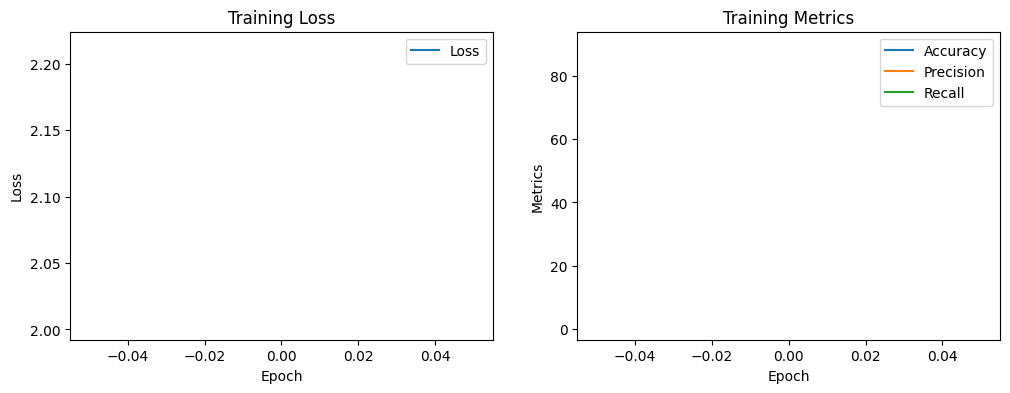

In [36]:
if __name__ == "__main__":
    config = yaml_reader()
    
    traindir = config["dataset_parameters"]["traindir"]
    testdir = config["dataset_parameters"]["testdir"]
    
    rate_learning = config["training_parameters"]["learning_rate"]
    epochs = config["training_parameters"]["num_epochs"]
    bs = config["training_parameters"]["batch_size"]
    dropout_rate = config["model_parameters"]["dropout_rate"]
    wd = config["model_parameters"]["weight_decay"]
    
    data_train = pd.read_csv(traindir).to_numpy()
    data_test = pd.read_csv(testdir).to_numpy()
    
    X_train, y_train = preprocess_data(data_train)
    X_test, y_test = preprocess_data(data_test)
    
    model = MnistClassifier()
    optimizer = AdamOptimizer(model.parameters(), lr=rate_learning, beta1=0.9, beta2=1.1, eps=1e-8)
    criterion = CrossEntropyLoss()
    
    train_losses, train_accuracies, train_precisions, train_recalls = train(model, optimizer, criterion, X_train, y_train, epochs=epochs, batch_size=bs)
    
    plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls)